In [363]:
from gurobipy import *
import random as rd
import json

### Looking at the data

In [364]:
# Opening JSON file
f = open('/Users/cha/Desktop/Code/optimization-project/data/medium.json')
data = json.load(f)
data.keys()
f.close()

In [365]:
data['horizon'], data['qualifications']

(22, ['F', 'G', 'A', 'D', 'J', 'C', 'H', 'E', 'B', 'I'])

In [366]:
data['staff']

[{'name': 'Olivia', 'qualifications': ['A', 'B', 'C'], 'vacations': [1, 2]},
 {'name': 'Liam', 'qualifications': ['A', 'D', 'E'], 'vacations': [1, 2]},
 {'name': 'Emma', 'qualifications': ['B', 'H'], 'vacations': [8, 9]},
 {'name': 'Noah',
  'qualifications': ['G', 'D', 'J', 'C', 'H', 'I'],
  'vacations': []},
 {'name': 'Amelia',
  'qualifications': ['F', 'G', 'J', 'E'],
  'vacations': [16, 15]}]

In [367]:
data['jobs'][8]

{'name': 'Job9',
 'gain': 25,
 'due_date': 18,
 'daily_penalty': 3,
 'working_days_per_qualification': {'E': 4, 'G': 3, 'H': 2}}

## Model and variable

In [368]:
# Instanciation du modèle
m = Model("Simple PL modelling")

# Création de variables
with open('/Users/cha/Desktop/Code/optimization-project/data/small.json') as f:
    data = json.load(f)

S = data['staff']
J = data['jobs']
Q = data['qualifications']
H = data['horizon']

X = m.addMVar(shape=(len(S), len(J), len(Q), H), vtype=GRB.BINARY)
Y = m.addMVar(shape=len(J), vtype=GRB.BINARY)
L = m.addMVar(shape=len(J))
E = m.addMVar(shape=len(J))
# maj du modèle
m.update()

## Defining constraints and objective function

In [369]:
def c1(x, i, t):
    res = 0
    for j in range(len(J)):
        for k in range(len(Q)):
            res += x[i, j, k, t]
    return res

def c4(x, j, k):
    res = 0
    for i in range(len(S)):
        for t in range(H):
            res += x[i, j, k, t]
    return res


# C1
for i in range(len(S)):
    for t in range(H):
        m.addConstr(c1(X, i, t) <= 1)

# C2
for i in range(len(S)):
    person = S[i]
    for t in person['vacations']:
        m.addConstr(c1(X, i, t) == 0)

# C3
for i in range(len(S)):
    person = S[i]
    for j in range(len(J)):
        job = J[j]
        for k in range(len(Q)):
            qualification = Q[k]
            if qualification not in person['qualifications'] and qualification not in list(job['working_days_per_qualification'].keys()):
                for t in range(H):
                    m.addConstr(X[i, j, k, t] == 0)

# C4
for j in range(len(J)):
    job = J[j]
    for k in range(len(Q)):
        qualification = Q[k]
        qualifications = list(job['working_days_per_qualification'].keys())
        if qualification in qualifications:
            njk = job['working_days_per_qualification'][qualification]
            m.addConstr(Y[j] * njk <= c4(X, j, k))

# C5
for j in range(len(J)):
    job = J[j]
    for k in range(len(Q)):
        qualification = Q[k]
        qualifications = list(job['working_days_per_qualification'].keys())
        if qualification in qualifications:
            njk = job['working_days_per_qualification'][qualification]
            m.addConstr(c4(X, j, k) <= njk)

# C6
for i in range(len(S)):
    for j in range(len(J)):
        for k in range(len(Q)):
            for t in range(H):
                m.addConstr(X[i, j, k, t] * t <= E[j])

# C7
for j in range(len(J)):
    job = J[j]
    dj = job["due_date"]
    m.addConstr(E[j] - dj <= L[j])

# Ej <= H
for j in range(len(J)):
    m.addConstr(E[j] <= H)

# Lj >= 0
for j in range(len(J)):
    m.addConstr(L[j] >= 0)

# Ej > 0
for j in range(len(J)):
    m.addConstr(E[j] >= 1)

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


### Fonction objectif 1 : Maximiser le bénéfice

In [370]:
def obj1(Y, L):
    res = 0
    for j in range(len(J)):
        job = J[j]
        gj = job["gain"]
        cj = job["daily_penalty"]
        res += (Y[j] * gj - L[j] * cj)
    return res

m.setObjective(
    obj1(Y, L),
    GRB.MAXIMIZE
)

### Fonction objectif 2 : Minimiser le nombre de projets sur lesquels un quelconque collaborateur est affecté

si x ≥ x0, imposer la contrainte x − x0 < M.δ (avec M un majorant de x) implique que δ = 1

In [371]:
# C'est un => qu'il faut introduire : si le nombre de jour sur lequel la personne travaille est supérieur à 1 alors la variable P[i, j] vaut 1

def working_on_project(X, i, j):
    res = 0
    for k in range(len(Q)):
        for t in range(H):
            res += X[i, j, k, t]
    return res

P = m.addMVar(shape=(len(S), len(J)), vtype=GRB.BINARY)
Z2 = m.addMVar(shape=1)

# Contrainte : nombre de projets par personne
for i in range(len(S)):
    for j in range(len(J)):
        res = working_on_project(X, i, j)
        m.addConstr(res - 1 <= H * len(Q) * 1000 * P[i, j] + 1)
        m.addConstr(H * len(Q) * 1000 * (1- P[i, j]) <= res - 1)

def obj2(P, i):
    res = 0
    for j in range(len(J)):
        res += P[i, j]
    return res

for i in range(len(S)):
    m.addConstr(obj2(P, i) <= Z2)

m.setObjective(
    Z2,
    GRB.MINIMIZE
)

### Fonction objectif 3 : Executer le projet le plus long en un minimum de jours

In [372]:
D = m.addMVar(shape=len(J))
Z3 = m.addMVar(shape=1)

for j in range(len(J)):
    m.addConstr(res <= Z3)

for j in range(len(J)):
    m.addConstr(E[j] - D[j] <= Z3)

m.setObjective(
    Z3,
    GRB.MINIMIZE
)

## Optimizing the model

In [373]:
# Paramétrage (mode mute)
m.params.outputflag = 0
# Résolution du PL
m.optimize()
print("X: ", X.X, "\n")
print("Y: ", Y.X, "\n")
print("L: ", L.X, "\n")
print("E: ", E.X, "\n")
print("objective: ", m.objVal)

X:  [[[[ 0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.]]

  [[ 0.  0.  1.  0.  0.]
   [ 1.  1.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.]]

  [[ 0.  0.  0.  0.  1.]
   [ 0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.]]

  [[ 0.  0.  0.  0.  0.]
   [ 0.  0.  0.  1.  0.]
   [ 0.  0.  0.  0.  0.]]

  [[ 0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.]]]


 [[[ 0.  0.  1.  0.  0.]
   [ 1.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.]]

  [[ 0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.]
   [-0. -0. -0. -0. -0.]]

  [[ 0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  1.]]

  [[ 0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.]
   [ 0.  0.  0.  1.  0.]]

  [[ 0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.]]]


 [[[ 0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.]
   [ 1.  0.  0.  0.  0.]]

  [[ 0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.]]

  [[ 0.  0.  0.  0.  0.]
   [-0. -0. -0. -0. -0.]
   [ 0.  0.  0.  0

In [374]:
matE = E.X
matX = X.X
matY = Y.X
matL = L.X

# Visualizing

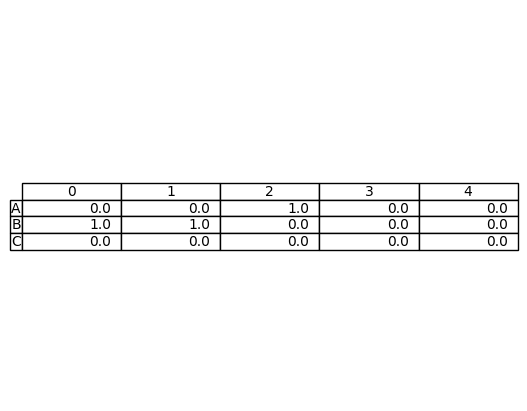

In [375]:
import matplotlib.pyplot as plt

personid = 0
projectid = 1
person0 = matX[personid]
fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

ax.table(cellText=person0[projectid], colLabels=[k for k in range(H)], rowLabels=["A", "B", "C"], loc='center')
plt.title(f"Person: {S[personid + 1]['name']}, Projet: {J[projectid + 1]['name']}", color="white")
plt.show()

In [376]:
def rendu_tot():
    for j in range(len(J)):
        if matE[j] < J[j]["due_date"]:
            print("Yes")
rendu_tot()

In [377]:
for i in range(len(S)):
    for t in range(H):
        res = 0
        for j in range(len(J)):
            for k in range(len(Q)):
                res += matX[i, j, k, t]
        print(res)

1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
